# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Ahmad Radesta
- **Email:** ahmadradesta95@gmail.com
- **ID Dicoding:** ahmad007

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [70]:
# Import standard libraries
import os
import random
import shutil
import pathlib
import pandas as pd
import numpy as np

# Import PIL for image processing
from PIL import Image

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

### Data Loading

In [4]:
!unzip "/content/drive/MyDrive/dataset (1)/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_277.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_281.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_285.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_289.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_29.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_33.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_37.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_41.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_45.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_49.j

In [108]:
def count_images_and_resolution(base_path):
    # Dictionary untuk menyimpan jumlah gambar per kelas
    class_count = {}

    # Dictionary untuk menyimpan jumlah gambar per resolusi
    resolution_count = {}

    for root, dirs, files in os.walk(base_path):
        # Mengabaikan folder root yang tidak memiliki gambar
        if root == base_path:
            continue
        class_name = os.path.basename(root)
        class_count[class_name] = 0  # Inisialisasi hitungan kelas

        for file in files:
            # Hanya proses file dengan ekstensi gambar
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        width, height = img.size
                        resolution = f"{width}x{height}"
                        if resolution not in resolution_count:
                            resolution_count[resolution] = 0
                        resolution_count[resolution] += 1

                        # Tambahkan ke hitungan kelas hanya jika gambar valid
                        class_count[class_name] += 1
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
            else:
                print(f"Skipped non-image file: {file}")

    return class_count, resolution_count

# Path ke folder utama
base_path = "/content/fruits-360_original-size/fruits-360-original-size"

class_count, resolution_count = count_images_and_resolution(base_path)

# Menampilkan hasil
print("Jumlah gambar per kelas:")
for class_name, count in class_count.items():
    print(f"{class_name}: {count}")

print("\nJumlah gambar per resolusi:")
for resolution, count in resolution_count.items():
    print(f"{resolution}: {count}")

Streaming output truncated to the last 5000 lines.
569x498: 1
539x497: 1
569x513: 1
523x496: 1
557x495: 1
508x515: 2
599x497: 1
488x590: 1
580x496: 1
509x580: 2
494x521: 2
497x522: 1
518x496: 1
572x513: 1
556x527: 1
553x527: 2
529x496: 1
491x589: 3
597x528: 1
503x523: 1
535x525: 1
587x498: 1
607x498: 2
483x518: 2
514x515: 1
542x495: 1
548x496: 2
574x497: 1
568x497: 1
591x498: 1
607x528: 2
530x525: 1
520x524: 1
584x527: 1
508x597: 1
500x515: 2
491x516: 1
516x524: 1
497x517: 1
503x580: 1
571x527: 1
510x575: 1
553x514: 2
499x593: 2
596x497: 2
501x590: 1
545x526: 1
568x498: 2
616x528: 4
599x498: 2
511x523: 1
531x498: 1
562x498: 1
500x595: 1
541x497: 1
517x577: 2
528x496: 2
513x515: 1
500x580: 2
534x496: 1
509x496: 1
515x599: 1
508x524: 1
490x592: 2
499x590: 1
574x513: 1
516x513: 1
496x594: 1
593x498: 1
540x497: 2
562x514: 1
597x499: 1
545x498: 1
583x528: 1
518x514: 1
505x524: 1
520x598: 1
505x581: 1
497x515: 1
590x496: 2
489x522: 1
571x495: 1
497x523: 2
485x519: 1
492x517: 1
508x498: 4
513

### Data Preprocessing

#### Split Dataset

In [109]:
train_dir = '/content/fruits-360_original-size/fruits-360-original-size/Training'
test_dir =  '/content/fruits-360_original-size/fruits-360-original-size/Test'
val_dir = '/content/fruits-360_original-size/fruits-360-original-size/Validation'

In [110]:
def count_images_and_classes(directory):
    total_images = 0
    classes = os.listdir(directory)  # Daftar subfolder (kelas)
    num_classes = len(classes)

    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Pastikan itu folder
            images = len([file for file in os.listdir(class_path) if file.endswith(('.jpg', '.jpeg', '.png'))])
            total_images += images

    return total_images, num_classes

# Hitung untuk masing-masing direktori
train_images, train_classes = count_images_and_classes(train_dir)
test_images, test_classes = count_images_and_classes(test_dir)
val_images, val_classes = count_images_and_classes(val_dir)

# Tampilkan hasil
print(f"Training: {train_images} gambar, {train_classes} kelas")
print(f"Test: {test_images} gambar, {test_classes} kelas")
print(f"Validation: {val_images} gambar, {val_classes} kelas")
print(f"Total gambar: {train_images + test_images + val_images}")

Training: 26219 gambar, 78 kelas
Test: 13040 gambar, 78 kelas
Validation: 13111 gambar, 78 kelas
Total gambar: 52370


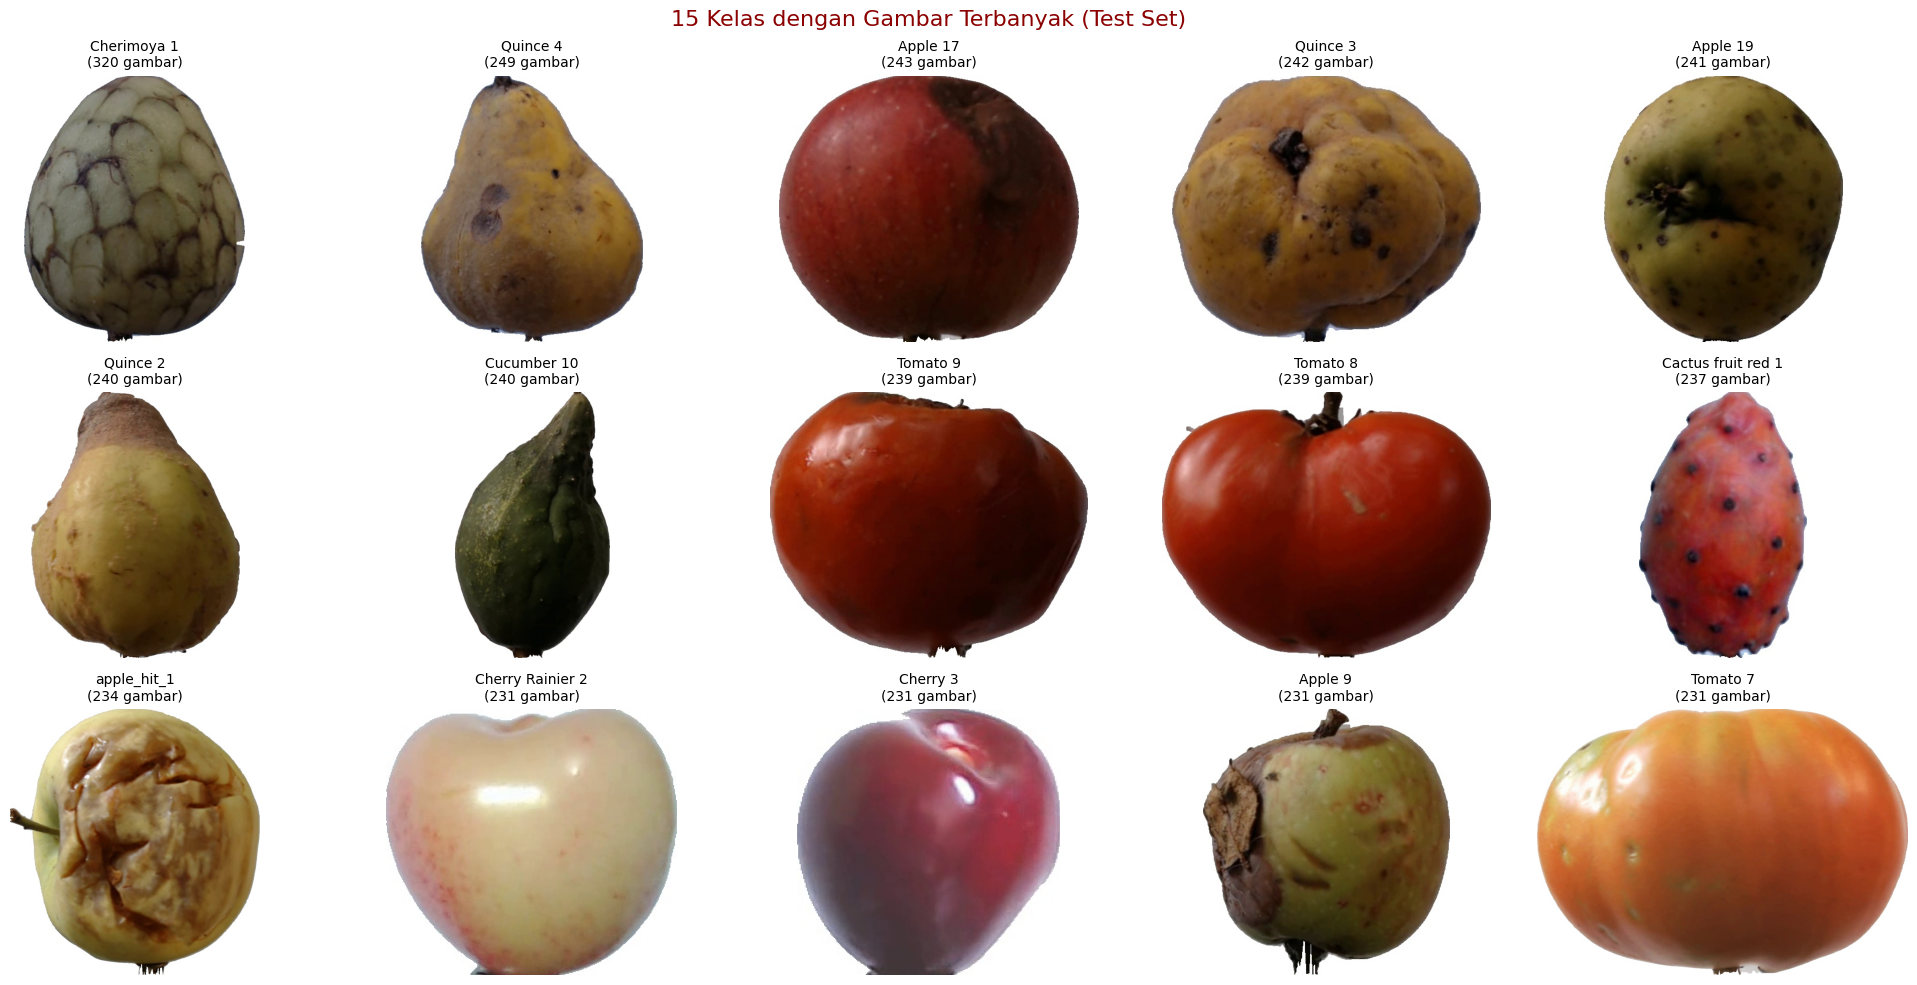

In [111]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter


# Hitung jumlah gambar per kelas
class_image_counts = {}
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_image_counts[class_name] = len(image_files)

# Ambil 15 kelas dengan jumlah gambar terbanyak
top_classes = sorted(class_image_counts.items(), key=lambda x: x[1], reverse=True)[:15]

# Tampilkan 1 gambar dari tiap kelas
plt.figure(figsize=(20, 10))
for i, (class_name, count) in enumerate(top_classes):
    class_path = os.path.join(test_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if image_files:
        img_path = os.path.join(class_path, image_files[0])
        img = mpimg.imread(img_path)

        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.title(f"{class_name}\n({count} gambar)", fontsize=10)
        plt.axis('off')

plt.suptitle("15 Kelas dengan Gambar Terbanyak (Test Set)", fontsize=16, color='darkred')
plt.tight_layout()
plt.show()


In [112]:
img_size = (100, 100)
batch_size = 32

In [115]:
selected_classes = ["Apple 10", "Apple 11", "Apple 12", "Apple 13", "Apple 14", "Apple 17", "Apple 18", "Apple 19", "Apple 5",
    "Apple 7", "Apple 8", "Apple 9", "Apple Core 1", "Apple Red Yellow 2", "Apple worm 1", "Banana 3",
    "Beans 1", "Blackberrie 1", "Blackberrie 2", "Blackberrie half rippen 1", "Blackberrie not rippen 1",
    "Cabbage red 1", "Cactus fruit green 1", "Cactus fruit red 1", "Caju seed 1", "Cherimoya 1", "Cherry 3",
    "Cherry 4", "Cherry 5", "Cherry Rainier 2", "Cherry Rainier 3", "Cherry Sour 1", "Cherry Wax Red 2",
    "Cherry Wax Red 3", "Cherry Wax not ripen 1", "Cherry Wax not ripen 2", "Cucumber 10", "Cucumber 9",
    "Gooseberry 1", "Pistachio 1", "Quince 2", "Quince 3", "Quince 4", "Tomato 1", "Tomato 10", "Tomato 5",
    "Tomato 7", "Tomato 8", "Tomato 9", "Tomato Cherry Maroon 1", "Tomato Cherry Orange 1",
    "Tomato Cherry Red 2", "Tomato Cherry Yellow 1", "Tomato Maroon 2", "apple_6", "apple_braeburn_1"]

In [117]:
# Lokasi folder baru
base_dir = '/content/fruitsnew'

train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

# Asal dataset
base_path = '/content/fruits-360_original-size/fruits-360-original-size'

# Buat struktur folder
for split in ['Training', 'Validation', 'Test']:
    for cls in selected_classes:
        src_path = os.path.join(base_path, split, cls)
        dst_path = os.path.join(base_dir, split, cls)
        os.makedirs(dst_path, exist_ok=True)

        # Salin file (maksimal 100 file per kelas agar cepat)
        for file_name in os.listdir(src_path)[:100]:
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                shutil.copy(os.path.join(src_path, file_name), dst_path)


In [118]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_gen = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 5599 images belonging to 56 classes.
Found 5410 images belonging to 56 classes.
Found 5407 images belonging to 56 classes.


## Modelling

In [121]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')  # Output sesuai jumlah kelas
])


In [122]:
# Compile model
optimizer = tf.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.001, restore_best_weights=True, mode='max', baseline=0.96)

In [126]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.2973 - loss: 2.6640 - val_accuracy: 0.7645 - val_loss: 0.7552
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.7862 - loss: 0.7008 - val_accuracy: 0.9140 - val_loss: 0.2462
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8840 - loss: 0.3492 - val_accuracy: 0.9612 - val_loss: 0.1301
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 174s 995ms/step - accuracy: 0.9339 - loss: 0.2059 - val_accuracy: 0.9222 - val_loss: 0.2231
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9306 - loss: 0.2014 - val_accuracy: 0.9536 - val_loss: 0.1398
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.9350 - loss: 0.1929 - val_accuracy: 0.9682 - val_loss: 0.0915
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9420 - loss: 0.1676 - val_accuracy: 0.9837 - val_loss: 0.0492
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 173s 987ms/step - accuracy: 0.9619 - loss: 0.1138 - va

## Evaluasi dan Visualisasi

In [132]:
loss, accuracy = model.evaluate(test_gen)
print(f"Akurasi pada Test Set: {accuracy * 100:.2f}%")
print(f"Loss pada Test Set: {loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 260ms/step - accuracy: 0.9876 - loss: 0.0417
Akurasi pada Test Set: 98.46%
Loss pada Test Set: 0.0488


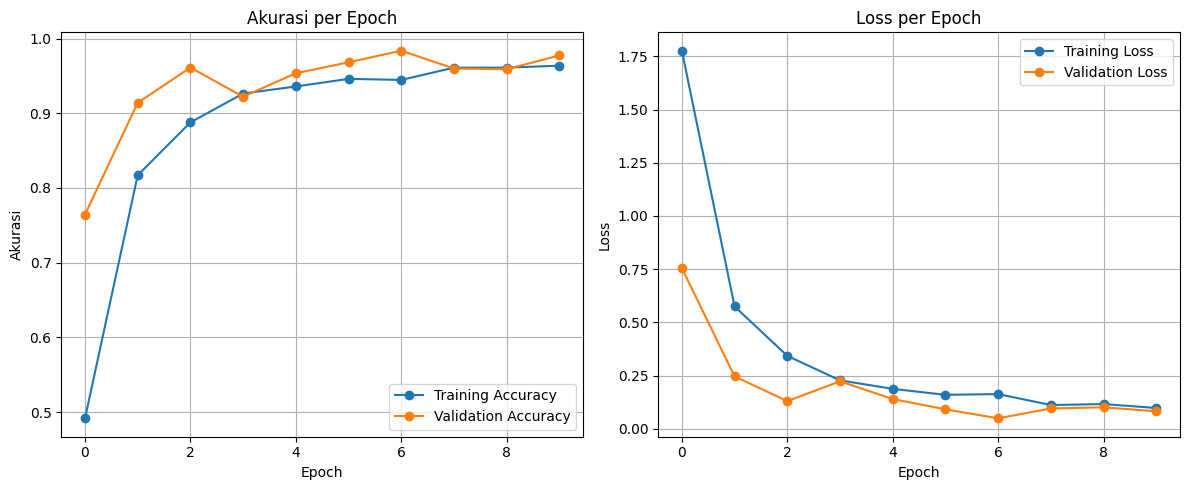

In [133]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Akurasi per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Konversi Model

In [134]:
model.save("model.h5")

In [135]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model


2025-05-01 18:47:23.758624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746125244.202184   77218 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746125244.327087   77218 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [136]:
save_path = os.path.join("models/klasifikasi-buah")
tf.saved_model.save(model, save_path)

In [137]:
# Load the Keras model
model_TFLITE = tf.keras.models.load_model('model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_TFLITE)
tflite_model = converter.convert()

# Save the converted model to a file
with open("converted_model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp992x_748'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 56), dtype=tf.float32, name=None)
Captures:
  136281431300944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136281431296144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136281431297680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136281431309968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136281431298832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136281431298448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136281431299600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136281431299024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136281422590032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136281422591760: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [138]:
# Buat konten yang akan ditulis ke dalam file
content = """
"Apple 10", "Apple 11", "Apple 12", "Apple 13", "Apple 14", "Apple 17", "Apple 18", "Apple 19", "Apple 5",
"Apple 7", "Apple 8", "Apple 9", "Apple Core 1", "Apple Red Yellow 2", "Apple worm 1", "Banana 3",
"Beans 1", "Blackberrie 1", "Blackberrie 2", "Blackberrie half rippen 1", "Blackberrie not rippen 1",
"Cabbage red 1", "Cactus fruit green 1", "Cactus fruit red 1", "Caju seed 1", "Cherimoya 1", "Cherry 3",
"Cherry 4", "Cherry 5", "Cherry Rainier 2", "Cherry Rainier 3", "Cherry Sour 1", "Cherry Wax Red 2",
"Cherry Wax Red 3", "Cherry Wax not ripen 1", "Cherry Wax not ripen 2", "Cucumber 10", "Cucumber 9",
"Gooseberry 1", "Pistachio 1", "Quince 2", "Quince 3", "Quince 4", "Tomato 1", "Tomato 10", "Tomato 5",
"Tomato 7", "Tomato 8", "Tomato 9", "Tomato Cherry Maroon 1", "Tomato Cherry Orange 1",
"Tomato Cherry Red 2", "Tomato Cherry Yellow 1", "Tomato Maroon 2", "apple_6", "apple_braeburn_1"
"""

# Tentukan path dan nama file
file_path = "/content/KlasifikasiBuah.txt"

# Tulis konten ke dalam file
with open(file_path, "w") as file:
    file.write(content.strip())


In [139]:
# Specify the folder to zip
folder_modles = '/content/models'
folder_tfjs_model = '/content/tfjs_model'

# Specify the output zip file name (without .zip extension)
output_modles= '/content/models'
output_tfjs_model = '/content/tfjs_model'

# Zip the folder
shutil.make_archive(output_modles, 'zip', folder_modles)
shutil.make_archive(output_tfjs_model, 'zip', folder_tfjs_model)

'/content/tfjs_model.zip'

In [ ]:
!pip freeze > requirements.txt

## Inference (Optional)

In [149]:
import tensorflow as tf
import numpy as np
import os

# Load model dari path .keras, .h5, atau SavedModel
model = tf.keras.models.load_model('/content/model.h5')  # Ganti path sesuai model kamu

# Daftar nama kelas sebagai list
class_names = [
    "Apple 10", "Apple 11", "Apple 12", "Apple 13", "Apple 14", "Apple 17", "Apple 18", "Apple 19", "Apple 5",
    "Apple 7", "Apple 8", "Apple 9", "Apple Core 1", "Apple Red Yellow 2", "Apple worm 1", "Banana 3",
    "Beans 1", "Blackberrie 1", "Blackberrie 2", "Blackberrie half rippen 1", "Blackberrie not rippen 1",
    "Cabbage red 1", "Cactus fruit green 1", "Cactus fruit red 1", "Caju seed 1", "Cherimoya 1", "Cherry 3",
    "Cherry 4", "Cherry 5", "Cherry Rainier 2", "Cherry Rainier 3", "Cherry Sour 1", "Cherry Wax Red 2",
    "Cherry Wax Red 3", "Cherry Wax not ripen 1", "Cherry Wax not ripen 2", "Cucumber 10", "Cucumber 9",
    "Gooseberry 1", "Pistachio 1", "Quince 2", "Quince 3", "Quince 4", "Tomato 1", "Tomato 10", "Tomato 5",
    "Tomato 7", "Tomato 8", "Tomato 9", "Tomato Cherry Maroon 1", "Tomato Cherry Orange 1",
    "Tomato Cherry Red 2", "Tomato Cherry Yellow 1", "Tomato Maroon 2", "apple_6", "apple_braeburn_1"
]

# Mapping indeks ke nama kelas
map_labels = {i: name for i, name in enumerate(class_names)}

# Contoh cetak 5 pertama
for k in list(map_labels)[:5]:
    print(f"{k}: {map_labels[k]}")


# Fungsi untuk preprocessing gambar
def images_preprocessing(filenames):
    image_tensors = []
    for filename in filenames:
        # Baca gambar dari file
        image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)

        # Resize gambar ke ukuran yang sesuai dengan input model
        image = tf.image.resize(image, [100, 100])  # Ganti ukuran sesuai input model

        # Normalisasi
        image = image / 255.0

        # Tambahkan dimensi batch
        image_tensor = tf.expand_dims(image, 0)

        image_tensors.append(image_tensor)

    return tf.concat(image_tensors, axis=0)


# Daftar gambar yang ingin diuji
filenames = [
    '/content/fruitsnew/Test/Apple Red Yellow 2/r0_103.jpg',
    '/content/fruitsnew/Test/Banana 3/r0_103.jpg',
    '/content/fruitsnew/Test/Cherimoya 1/r0_103.jpg'
]

# Preprocess
batch_images = images_preprocessing(filenames)

# Prediksi
predictions = model.predict(batch_images)

# Tampilkan hasil prediksi
print("Hasil Prediksi:")
for i, prediction in enumerate(predictions):
    predicted_class = tf.argmax(prediction).numpy()
    confidence = tf.reduce_max(prediction).numpy()
    print(f"{os.path.basename(filenames[i])}: {map_labels[predicted_class]} (confidence: {confidence:.2f})")


0: Apple 10
1: Apple 11
2: Apple 12
3: Apple 13
4: Apple 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Hasil Prediksi:
r0_103.jpg: Apple Red Yellow 2 (confidence: 1.00)
r0_103.jpg: Banana 3 (confidence: 1.00)
r0_103.jpg: Cherimoya 1 (confidence: 0.95)
